# Library Import

In [1]:
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score)
import matplotlib.pyplot as plt

# Load Data

t: time  
f: failures  
cum_f: cumulative failures

In [2]:
data = np.loadtxt('J1.csv', delimiter=',', skiprows=1, dtype=int)
data = np.insert(data, 0, [0, 0, 0], axis=0)

In [3]:
t = data[:, 0]
f = data[:, 1]
cum_f = data[:, 2]

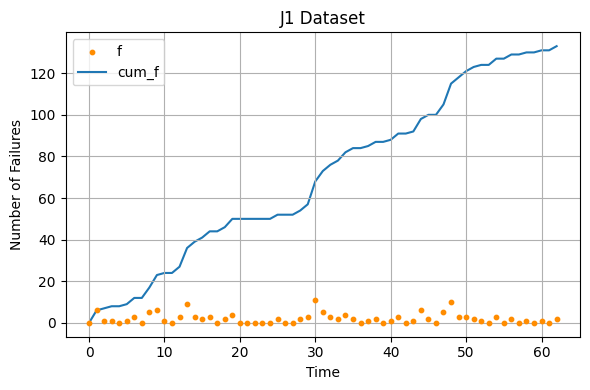

In [4]:
plt.figure(figsize=(6, 4))

plt.scatter(t, f, color='darkorange', s=10, label='f', zorder=2)
plt.plot(t, cum_f, label='cum_f', zorder=1)

plt.title('J1 Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

# Estimation

Preparation functions for parameter estimation

In [5]:
tiny = np.finfo(float).tiny  # Prevent log calculation errors (avoid log(0))


# Log-Logistic model function
def log_logistic(t, a, b, c):
    return a * (b * t)**c / (1 + (b * t)**c)


# Residual function for LSM estimation using Log-Logistic model
def log_logistic_lsm(params, t, cum_f):
    a, b, c = params
    return log_logistic(t, a, b, c) - cum_f


# Function to estimate parameter 'a' of the Log-Logistic model
def log_logistic_a(t, f, b, c):
    a = f * (1 + (b * t)**c) / (b * t)**c
    return a


# Negative log-likelihood function for the Log-Logistic model
def log_logistic_nll(params, t, f):
    b, c = params
    a = np.sum(f) * (1 + (b * t[-1])**c) / (b * t[-1])**c

    term1 = a * ((b * t[1:])**c / (1 + (b * t[1:])**c)
                 - (b * t[:-1])**c / (1 + (b * t[:-1])**c))
    term1[term1 < tiny] = tiny
    log_term1 = f[1:] * np.log(term1)

    term2 = a * ((b * t[-1])**c / (1 + (b * t[-1])**c)
                 - (b * t[0]**c) / (1 + (b * t[0])**c))

    log_facs = [np.sum([np.log(j) for j in range(1, i+1)]) for i in f[1:]]

    loglikelihood = np.sum(log_term1) - term2 - np.sum(log_facs)
    return -loglikelihood

Setup variables for parameter estimation

In [6]:
eps = np.sqrt(np.finfo(float).eps)  # Small epsilon to avoid division by zero

# Parameter initialization and bounds for LSM estimation
lsm_init_guess = [cum_f[-1] * 1.5, 0.1, 1]
lsm_bounds = ([cum_f[-1], eps, 0], [np.inf, np.inf, 10])

# Parameter initialization and bounds for MLE estimation
mle_init_guess = [0.1, 1]
mle_bounds = [(eps, np.inf), (0, 10)]

## LSM

### Trust Region Reflective algorithm

In [7]:
result = least_squares(log_logistic_lsm, lsm_init_guess, args=(t, cum_f),
                       method='trf', bounds=lsm_bounds)

trf_a, trf_b, trf_c = result.x
print(f'a: {trf_a}, b: {trf_b}, c: {trf_c}')

a: 12600.606454981924, b: 0.00016537652135568346, c: 0.9809009035727211


In [8]:
f_pred = log_logistic(t, trf_a, trf_b, trf_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 20.840441621247876
RMSE: 4.565133253394459
MAE: 3.8006281609980457
MAPE: 0.08796118556474009
R2 score: 0.9875484887768416


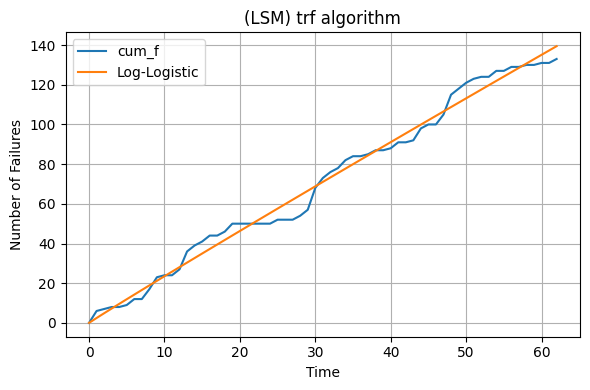

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(LSM) trf algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### dogleg algorithm

In [10]:
result = least_squares(log_logistic_lsm, lsm_init_guess, args=(t, cum_f),
                       method='dogbox', bounds=lsm_bounds)

dogbox_a, dogbox_b, dogbox_c = result.x
print(f'a: {dogbox_a}, b: {dogbox_b}, c: {dogbox_c}')

a: 248647.362874678, b: 4.957402965921142e-06, c: 0.9275000283425248


In [11]:
f_pred = log_logistic(t, dogbox_a, dogbox_b, dogbox_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 22.603079520140227
RMSE: 4.754269609534174
MAE: 3.8348225854731264
MAPE: 0.09321614945699018
R2 score: 0.986495367831552


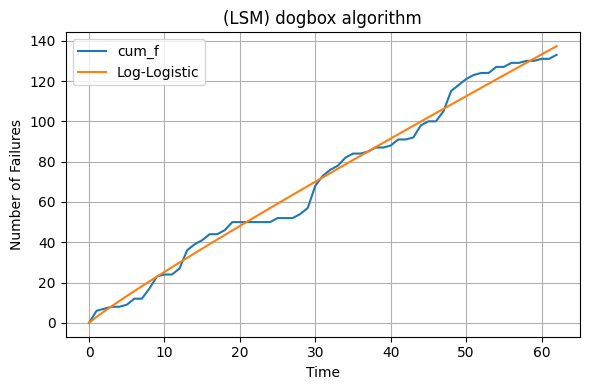

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(LSM) dogbox algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

## MLE

### Nelder-Mead algorithm

In [13]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='Nelder-Mead', bounds=mle_bounds)

nelder_mead_b, nelder_mead_c = result.x
nelder_mead_a = log_logistic_a(t[-1], np.sum(f), nelder_mead_b, nelder_mead_c)
print(f'a: {nelder_mead_a}, b: {nelder_mead_b}, c: {nelder_mead_c}')

a: 1944.9428614994101, b: 0.0009639846490588145, c: 0.9270596246023948


In [14]:
f_pred = log_logistic(t, nelder_mead_a, nelder_mead_b, nelder_mead_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.209855276214157
RMSE: 5.311295065820968
MAE: 4.106506067051437
MAPE: 0.09881906071009809
R2 score: 0.9831454949007735


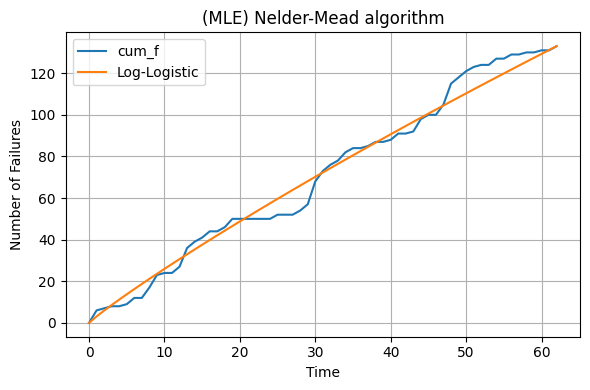

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) Nelder-Mead algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Powell algorithm

In [16]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='Powell', bounds=mle_bounds)

powell_b, powell_c = result.x
powell_a = log_logistic_a(t[-1], np.sum(f), powell_b, powell_c)
print(f'a: {powell_a}, b: {powell_b}, c: {powell_c}')

a: 1146.102812298357, b: 0.001976683694806895, c: 0.9672368141870074


In [17]:
f_pred = log_logistic(t, powell_a, powell_b, powell_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 27.149855844346583
RMSE: 5.210552355014445
MAE: 4.035436551979701
MAPE: 0.0936319914058926
R2 score: 0.9837788113660534


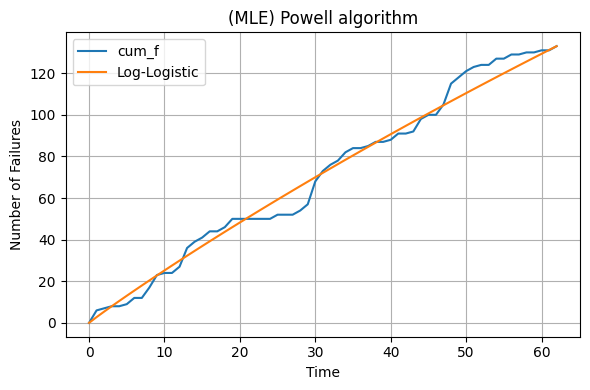

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) Powell algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### L-BFGS-B algorithm

In [19]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='L-BFGS-B', bounds=mle_bounds)

l_bfgs_b_b, l_bfgs_b_c = result.x
l_bfgs_b_a = log_logistic_a(t[-1], np.sum(f), l_bfgs_b_b, l_bfgs_b_c)
print(f'a: {l_bfgs_b_a}, b: {l_bfgs_b_b}, c: {l_bfgs_b_c}')

a: 1947.6601397613501, b: 0.0009622979975200956, c: 0.9270153046989315


In [20]:
f_pred = log_logistic(t, l_bfgs_b_a, l_bfgs_b_b, l_bfgs_b_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.209930351481823
RMSE: 5.311302133326801
MAE: 4.106573266244225
MAPE: 0.09881967101118172
R2 score: 0.9831454500456522


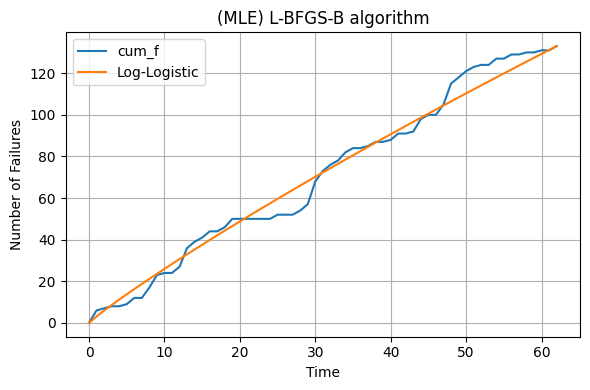

In [21]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) L-BFGS-B algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### truncated Newton (TNC) algorithm

In [22]:
reuslt = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='TNC', bounds=mle_bounds)

tnc_b, tnc_c = result.x
tnc_a = log_logistic_a(t[-1], np.sum(f), tnc_b, tnc_c)
print(f'a: {tnc_a}, b: {tnc_b}, c: {tnc_c}')

a: 1947.6601397613501, b: 0.0009622979975200956, c: 0.9270153046989315


In [23]:
f_pred = log_logistic(t, tnc_a, tnc_b, tnc_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.209930351481823
RMSE: 5.311302133326801
MAE: 4.106573266244225
MAPE: 0.09881967101118172
R2 score: 0.9831454500456522


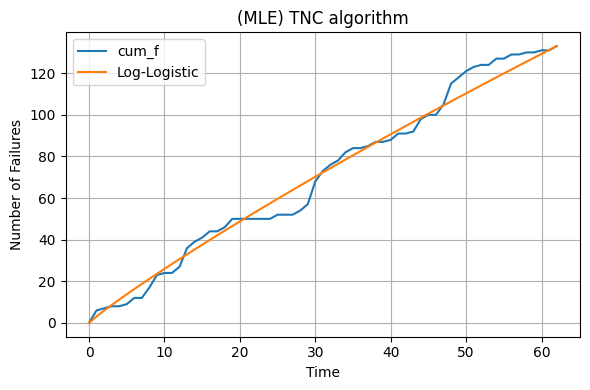

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) TNC algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Optimization BY Quadratic Approximations (COBYQA) algorithm

In [25]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='COBYQA', bounds=mle_bounds)

cobyqa_b, cobyqa_c = result.x
cobyqa_a = log_logistic_a(t[-1], np.sum(f), cobyqa_b, cobyqa_c)
print(f'a: {cobyqa_a}, b: {cobyqa_b}, c: {cobyqa_c}')

a: 1947.6125105685862, b: 0.0009623276639845992, c: 0.9270161316041228


In [26]:
f_pred = log_logistic(t, cobyqa_a, cobyqa_b, cobyqa_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.20992546733918
RMSE: 5.311301673539094
MAE: 4.106571959528003
MAPE: 0.09881964459683207
R2 score: 0.9831454529637744


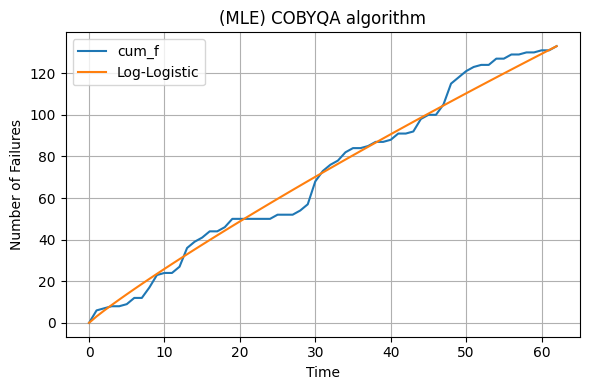

In [27]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) COBYQA algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Sequential Least Squares Programming (SLSQP)

In [28]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='SLSQP', bounds=mle_bounds)

slsqp_b, slsqp_c = result.x
slsqp_a = log_logistic_a(t[-1], np.sum(f), slsqp_b, slsqp_c)
print(f'a: {slsqp_a}, b: {slsqp_b}, c: {slsqp_c}')

a: 1953.9982138294524, b: 0.0009584207294443588, c: 0.9269246124346587


In [29]:
f_pred = log_logistic(t, slsqp_a, slsqp_b, slsqp_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.20926546577281
RMSE: 5.311239541366291
MAE: 4.106698187795143
MAPE: 0.0988173408231026
R2 score: 0.9831458472940415


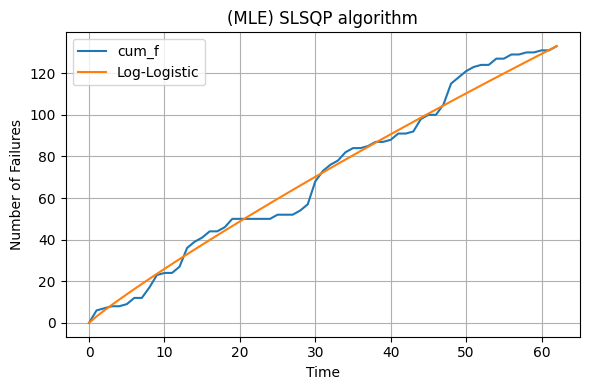

In [30]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) SLSQP algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Trust-Region algorithm

In [31]:
result = minimize(log_logistic_nll, mle_init_guess, args=(t, f),
                  method='trust-constr', bounds=mle_bounds)

trust_constr_b, trust_constr_c = result.x
trust_constr_a = log_logistic_a(t[-1], np.sum(f), trust_constr_b, trust_constr_c)
print(f'a: {trust_constr_a}, b: {trust_constr_b}, c: {trust_constr_c}')

a: 1947.6511319987255, b: 0.0009623035173933346, c: 0.9270154301226267


In [32]:
f_pred = log_logistic(t, trust_constr_a, trust_constr_b, trust_constr_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.20993157984435
RMSE: 5.3113022489634645
MAE: 4.10657309807964
MAPE: 0.09881967553540591
R2 score: 0.9831454493117441


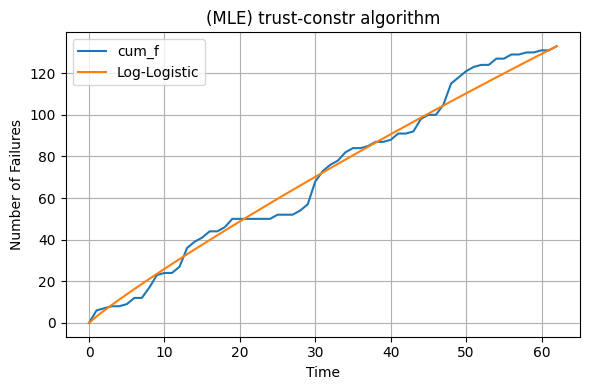

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Log-Logistic')

plt.title('(MLE) trust-constr algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()